## Final Project
## Uber Pickups in New York City

By Candice Shu Zhou (sz1710)


### Overview

Uber fundementally changed the way we think about for-hire rides. I am interested in exploring the trend of Uber pickups in NYC, specifically when and where do the rides take place, from which I believe we can draw some useful conclusions on people's communting habits in the city. I am also curious about the total number of Ubers in comparison to number of Yellow Cabs in NYC - do we have more cabs or taxis - so this project will also compare the number of Uber and Yellow Cab pickups in a day by hours.

The project will explore these issues in several steps.
1. Data description and data source
2. Discuss the tools and packages, as well as key functions used to process the data
3. When do people demand the most Uber rides in one day? -- Interpret the data to analyze the trend in Uber pickups by hours in one day
4. On which day in a week do people demand more Uber rides? -- Interpret the data to analyze the trend in Uber pickups by weekdays in one week
5. Where are the pickups? -- Map the Uber pickup location in NYC
6. Compare Uber vs. Yellow Cab pickups in June 2014

This project is inspired by FiveThirtyEight's extensive analysis of [Uber and its impact on NYC traffic](https://fivethirtyeight.com/tag/uber/).

### Data Source

The project majorly uses two data sources.

Data of Uber pickups comes from [here](https://github.com/fivethirtyeight/uber-tlc-foil-response/tree/master/uber-trip-data), obtained by FiveTHirtyEight from the [NYC Taxi & Limousine Commission (TLC)](http://www.nyc.gov/html/tlc/html/home/home.shtml) by submitting a Freedom of Information Law request on July 20, 2015. The data set consists of pickup date, time and location (latitude and longtitude) of all Uber rides from April to September 2014, and from January to June 2015. To have a specific focus for data intrepretation and analysis, and to have a comparison of pickups across one year while elimiating noises from various months (and holiday weeks), I will be primarily using **Uber pickup data of June 2014**. Nevertheless, in the middle of the project, I will temporily zoom out to observe a semi-annual trend with a larger data set from January - June 2015.

Data of Yellow Cab trip records directly come from [TLC Trip Record Data](http://www.nyc.gov/html/tlc/html/about/trip_record_data.shtml). Likewise, to draw mainful comparison across Yellow Cab and Uber, I will also be using data for **Yellow Cab trip records in June 2014**.

### Packages

In the analysis below, I'm goint to use the following modules and packages:
* `sys` for printing the current python version
* `pandas` package which helps import, manipulate, merge and analyze the data
* `matplotlib` which assists in data plotting
* `matplotlib.pyplot` which provides a plotting framework
* `numpy` which handles mathematical operations and manipulations on the data
* `datetime` module which helps manupulate date and time 
* `zipfile` for extracting data from a zip file
* `requests`, `io` which for importing data sets from the internet
* `basemap` which maps the data

In [43]:
import sys
import pandas as pd
from matplotlib import cm
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
import zipfile as zf            # zip file tools 
import requests, io             # internet and input tools  
from mpl_toolkits.basemap import Basemap

%matplotlib inline

print('Python version: ', sys.version)
print('Pandas version: ', pd.__version__)
print('Today: ', dt.date.today())

Python version:  3.6.1 |Anaconda 4.4.0 (x86_64)| (default, May 11 2017, 13:04:09) 
[GCC 4.2.1 Compatible Apple LLVM 6.0 (clang-600.0.57)]
Pandas version:  0.20.1
Today:  2017-12-20


### Part 1: Defining Data Processing Functions

#### extractDateTime (df, column)
This function extracts hour, day, and weekday from the datetime series. It takes in two inputs: a dataframe, and the name of the datetime column. Then it creates new columns corresponding to each of the three datetime related attributes.

In [2]:
# define a function that extracts datetime and create new columns
def extractDateTime(df, column):
    # extract the hour
    df['Hour'] = df[column].apply(lambda x:x.hour)
    # extract the day
    df['Day'] = df[column].apply(lambda x:x.day)
    # extrac the weekday
    df['Weekday'] = df[column].apply(lambda x: x.strftime('%A'))

#### hourlyPickUp (df, hourCol, dtCol)
This function helps compute number of hourly pickups. It takes in three inputs: the dataframe, the column associated with hour, and the column associated with datetime. It groups the data by hours, and counts number of pickups in each hour. Eventually, it returns an average number of pickups in one day by hour.

In [3]:
def hourlyPickUp(df, hourCol, dtCol): 
    df_byhour = df.groupby([hourCol])[dtCol].count()
    df_byhour = pd.DataFrame(df_byhour)
    df_byhour = df_byhour.rename(columns = {dtCol:'PickUps'})
    df_byhour['Average_PickUp'] = round(df_byhour['PickUps']/30,0)
    return df_byhour

#### drawMap (title, hourBegin, hourEnd, weekday = True)

This function helps draw hexbin heat map that demonstrates where the Uber pickups take place. It takes in three parameters -- the title of the graph, the begining hour, the ending hour -- and two parameters, `weekday` and `zoomIn`, set to be `False` by default. The begining and ending hour specifies the time range of the data, which will be used to plot the heap map. `weekday` parameter, if set to be `True`, means the map should exclude data from weekends. `zoomIn` parameter, if set to be `True`, means that the map will zoom in closer towards Manhattan region in NYC.

In [26]:
# define function for plotting more graphs - pickup locations in morning and at night for workdays
def drawMap (title, hourBegin, hourEnd, weekday=False, zoomIn=False):
    # set upper and lower boundary for hour
    hourUp = uber_jun14.Hour>=hourBegin
    hourLow = uber_jun14.Hour<=hourEnd
    
    # include only data from workday (excludes Saturday and Sunday)
    if weekday:
        weekdayUp = uber_jun14['Weekday'] != "Saturday"
        weekdayLow = uber_jun14['Weekday'] != "Sunday"
    else:
        weekdayUp = True
        weekdayLow = True
        
    # lon and lan uses + or -0.08 to zoom into the map
    if zoomIn:
        zoom = 0.08
    else:
        zoom = 0
    
    # 40.876172, -73.719574 upper right
    # 40.574828, -74.070428 lower left
    nyc_m = Basemap(projection='merc',
                    resolution = 'l', area_thresh = 1000.0, 
                    llcrnrlon=-74.20+zoom, llcrnrlat=40.57+zoom, # lower left hand cornoer lon, lower left hand corner lat
                    urcrnrlon=-73.72-zoom, urcrnrlat=40.88-zoom)  # upper right hand corner lon, upper right corner lat

    # plot data that satisfies the hour condition (between upper and lower hour boundary) and weekday condition
    x,y = nyc_m(uber_jun14[hourUp & hourLow & weekdayUp & weekdayLow].Lon.values, 
              uber_jun14[hourUp & hourLow & weekdayUp & weekdayLow].Lat.values)
    nyc_m.hexbin(x,y, bins='log', cmap=cm.hot, gridsize=1000)

    plt.title(title+'\n',fontsize = 15)
    
    plt.colorbar(label = "\n Log Concentration",fraction=0.038, pad=0.04)
    plt.show()

### Part 2: Uber Pickups by Hour in One Typical Day

This part essentially addresses the question: how does the number of Uber pickup vary by hour in a single day? The question will be answered by zooming into the data from a single month in 2014.

The cell below will read in data from [FiveThirtyEight's database](https://github.com/fivethirtyeight/uber-tlc-foil-response), specifically data of June 2014 under the uber-trip-data folder.

In [10]:
url_path = 'https://raw.githubusercontent.com/fivethirtyeight/'
url = url_path + 'uber-tlc-foil-response/master/uber-trip-data/uber-raw-data-jun14.csv'

# Here is path to file saved locally
# path = "/Users/candicezs/Documents/Academic/Data_Bootcamp/Project/"
# path += "uber-raw-data-jun14.csv"

uber_jun14 = pd.read_csv(url)

In [11]:
uber_jun14.head()

,Date/Time,Lat,Lon,Base
0,6/1/2014 0:00:00,40.7293,-73.9920,B02512
1,6/1/2014 0:01:00,40.7131,-74.0097,B02512
2,6/1/2014 0:04:00,40.3461,-74.6610,B02512
3,6/1/2014 0:04:00,40.7555,-73.9833,B02512
4,6/1/2014 0:07:00,40.6880,-74.1831,B02512


Now we need to convert the Date/Time colomn into datetime format, and extract hour, day, and weekday information of each trip record to prepare for further analysis. The extraction is completed using an early function extractDateTime(dt, column).

In [12]:
# convert Date/Time column to datetime format
uber_jun14['Date/Time'] = pd.to_datetime(uber_jun14['Date/Time'], format = '%m/%d/%Y %H:%M:%S')
# use extractDateTime() function to extract the datetime
extractDateTime(uber_jun14, 'Date/Time')

In [91]:
uber_jun14.head()

,Date/Time,Lat,Lon,Base,Hour,Day,Weekday
0,2014-06-01 00:00:00,40.7293,-73.9920,B02512,0,1,Sunday
1,2014-06-01 00:01:00,40.7131,-74.0097,B02512,0,1,Sunday
2,2014-06-01 00:04:00,40.3461,-74.6610,B02512,0,1,Sunday
3,2014-06-01 00:04:00,40.7555,-73.9833,B02512,0,1,Sunday
4,2014-06-01 00:07:00,40.6880,-74.1831,B02512,0,1,Sunday


Now, to see a Uber pickup trend varying by hour, we group the data by Hour column, and count the number of pickups that took place in each hour (throughout the whole month). And then, we **divide the number by 30 to obtain a daily average pickup number by hour.**

In [13]:
# group the data by hours
uber_jun14_byhour = hourlyPickUp(uber_jun14, 'Hour', 'Date/Time')
uber_jun14_byhour.head()

,PickUps,Average_PickUp
Hour,,
0,14514,484.0
1,9167,306.0
2,6189,206.0
3,6937,231.0
4,7701,257.0


### Data Visualization

Now it's time to visualize the data!

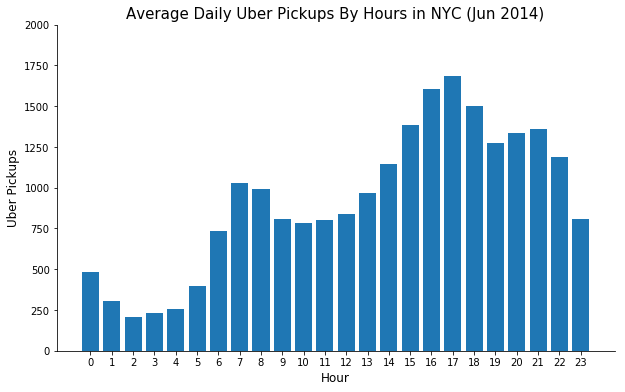

In [14]:
fig, ax = plt.subplots(figsize = (10,6))

plt.bar(uber_jun14_byhour.index, uber_jun14_byhour.Average_PickUp, label='Uber')

ax.set_xticks(range(0,24))
ax.set_ylim(0,2000)

ax.set_xlabel('Hour', fontsize = 12)
ax.set_ylabel('Uber Pickups', fontsize = 12)
ax.set_title('Average Daily Uber Pickups By Hours in NYC (Jun 2014)', fontsize=15)

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
plt.show()

The trend corresponds with our expectation of rush hours. The rush hour of New York is from 5am to 9am in the morning, and from 3pm to 6pm in the evening, and Uber pickups happen most frequently in these two hour range. Number of pickups is the least from 1am - 4am, likely because a majority of Uber drivers are not full time drivers, and the demand for rides is the lowest during that time.

### Part 3: Uber Pickups by Weekdays in One Month

In [15]:
#group the data by weekdays
uber_jun14_wd = uber_jun14.groupby(['Weekday'])['Date/Time'].count()
#convert to dataframe
uber_jun14_wd = pd.DataFrame(uber_jun14_wd)

To have a general understanding of the trend in Uber pickups by weekdays in a month (June 2014), I grouped the data by weekdays and counted the number of pickups in each weekday in one month. Again, divide the number by 4 to obtain average number of pickups in each weekday in one month. Before I analyzed the data, my asusmption was perhaps weekends will have the most number of rides, since people are more likely to hang out for food and entertainment on weekends.

In [16]:
#rename Date/Time column
uber_jun14_wd=uber_jun14_wd.rename(columns = {'Date/Time':'PickUps'})
#obtain average pickups over one day by hour
uber_jun14_wd["Average_PickUps"]=round(uber_jun14_wd["PickUps"]/4,0)
#sort weekday
uber_jun14_wd = uber_jun14_wd.reindex(['Monday', 'Tuesday','Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

uber_jun14_wd

,PickUps,Average_PickUps
Weekday,,
Monday,94655,23664.0
Tuesday,88134,22034.0
Wednesday,99654,24914.0
Thursday,115325,28831.0
Friday,105056,26264.0
Saturday,81364,20341.0
Sunday,79656,19914.0


### Data Visualization

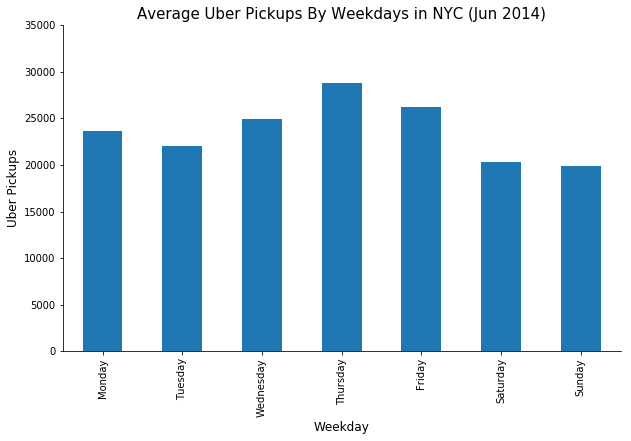

In [17]:
fig, ax = plt.subplots(figsize = (10,6))
uber_jun14_wd.Average_PickUps.plot(ax = ax, kind='bar')

ax.set_xlabel('Weekday', fontsize = 12)
ax.set_ylabel('Uber Pickups', fontsize = 12)
ax.set_title('Average Uber Pickups By Weekdays in NYC (Jun 2014)', fontsize=15)

ax.set_ylim(0,35000)

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
plt.show()

In contrast in what I assumed - that Saturday and Sunday will have the most number of pickups - the data from June 2014 suggests that Thursday is the day when people demand the most Uber rides, followed by Friday and Wednesday. As a matter of fact, numbers of Uber rides on weekends are the lowest in the week. The most reasonable explanation is that rides on weekdays are much higher because of the exogenous demand for rides to work and back home from work. To add on to that, for those who go out on weekends, maybe they perfer to drive themselves (as family outings) instead of taking Uber. On the other hand, from the demand side, maybe some part time Uber drivers prefer to take some time off and not provide rides during weekends, which can also contribute to overall lower number of Uber pickups on weekends.

### Part 4: Now compare uber pickups on each day during a week with a larger data set

To better understand what is happening by hour on each weekday, I am using **a larger data set (Jan-Jun 2015)** and trying to **isolate the effects of weekdays from the trend in hourly pickups**.

In [40]:
# The new data set is stored in a zip file, therefore I use the zipfile module to extract the file.
url = 'https://github.com/fivethirtyeight/uber-tlc-foil-response/raw/master'
url += '/uber-trip-data/uber-raw-data-janjune-15.csv.zip'
r = requests.get(url) 

# convert bytes to zip file  
mlz = zf.ZipFile(io.BytesIO(r.content)) 

# Backup: local path
# path = "/Users/candicezs/Documents/Academic/Data_Bootcamp/Project/uber-pickups-in-new-york-city/uber-raw-data-janjune-15.csv"

In [39]:
mlz.namelist()

['uber-raw-data-janjune-15.csv',
 '__MACOSX/',
 '__MACOSX/._uber-raw-data-janjune-15.csv']

In [ ]:
uber2015 = pd.read_csv(mlz.open(mlz.namelist()[0r]), usecols = ["Pickup_date"])

In [42]:
uber2015.head()

,Pickup_date
0,2015-05-17 09:47:00
1,2015-05-17 09:47:00
2,2015-05-17 09:47:00
3,2015-05-17 09:47:00
4,2015-05-17 09:47:00


In [20]:
uber2015['Pickup_date'] = pd.to_datetime(uber2015["Pickup_date"], format = '%Y-%m-%d %H:%M:%S')

# extract the date and time using extractDateTime() function
extractDateTime(uber2015, "Pickup_date")

In [8]:
uber2015.head()

,Pickup_date,Hour,Day,Weekday
0,2015-05-17 09:47:00,9,17,Sunday
1,2015-05-17 09:47:00,9,17,Sunday
2,2015-05-17 09:47:00,9,17,Sunday
3,2015-05-17 09:47:00,9,17,Sunday
4,2015-05-17 09:47:00,9,17,Sunday


Now, in order to isolate the effect of weekday from hourly pickup trend, I am grouping the data frame by hour and by weekday, and then counting the number of pick up. As a result, I obtain a new dataframe that summarizes the average number of pickups by hour through Monday to Sunday, with data from Jan-Jun, 2015.

In [9]:
uber2015_group = uber2015.groupby(['Hour','Weekday'])['Pickup_date'].count()

In [10]:
#convert to dataframe
uber2015_group = pd.DataFrame(uber2015_group)

In [11]:
#rename Date/Time column
uber2015_group=uber2015_group.rename(columns = {'Pickup_date':'PickUps'})
#obtain average pickups over one day by hour (there are 6 months * 4 weeks per month in the data set)
uber2015_group["Average_PickUps"]=round(uber2015_group["PickUps"]/4/6,0)

uber2015_group.head()

PickUps  Average_PickUps
Hour Weekday                           
0    Friday      85939           3581.0
     Monday      50060           2086.0
     Saturday   145811           6075.0
     Sunday     156949           6540.0
     Thursday    66310           2763.0

### Data Visualization

The following diagram illustrates the average Uber pickups each day by hours and weekdays in NYC, from Jan-Jun 2015.

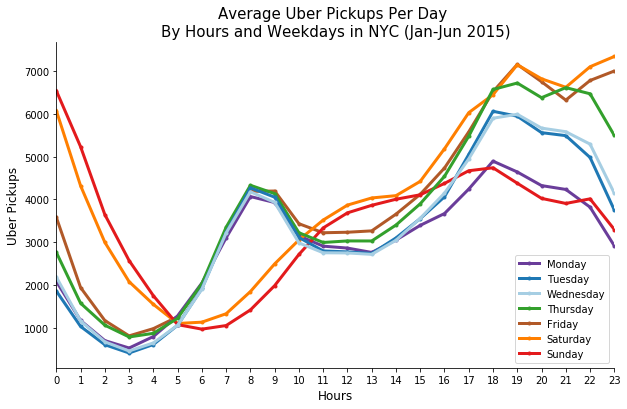

In [81]:
fig, ax = plt.subplots(figsize = (10,6))

uber2015_group.Average_PickUps.unstack().plot(ax=ax,cmap=plt.get_cmap('Paired_r'),style='.-',lw=3)

ax.set_xlabel('Hours', fontsize = 12)
ax.set_ylabel('Uber Pickups', fontsize = 12)
ax.set_title('Average Uber Pickups Per Day \nBy Hours and Weekdays in NYC (Jan-Jun 2015)', fontsize=15)

# change the ordering of the legend
handles,labels = ax.get_legend_handles_labels()
order = [1,5,6,4,0,2,3]
ax.legend([handles[i] for i in order],[labels[i] for i in order])

ax.set_xticks(range(0,24))

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
plt.show()

Here are a few main observations from the data visualization:

* Uber pickups on workdays and on weekends have two distinctive patterns:
* **On workdays**: the plotted lines converge from 5am to 11am, which corresponds to the rush hours in the morning; the lines slightly diverge for the rest of the day.
    * For **late night and early morning hours (0am - 3am)**, Monday - Wednesday have relatively lower number of pickups, and Thursday and Friday have more pickups, likely because people are leaving work late to catch up with deadlines, or people are enjoying more nightlife towards the end of the week.
    * For **afternoon and night hours (5pm - 11pm)**, Thursday and Friday have the most rides, followed by Wednesday and Tuesday, and then Monday with the least rides. The data implies that people in NYC perfer to hangout late at night on Thursday and Friday, specifically on Friday when the number of rides actually increases after 9pm, in contrast to decreasing trends at that time on other weekdays. Monday has significantly low demand for rides after 6pm, probably because fewer people dine out or hang out late at the beginning of a week.

* **On weekends**: the plotted lines for Saturday and Sunday are close between 0am - 3pm. Afterwards, we see the lines diverge.
    * For **late afternoon (3pm and onwards)**, Saturday has a lot more uber pickups than Sunday. People likely have fewer demand for outings on Sunday since they want to stay at home and get prepared for next week's works.
    * Interestingly, pickup numbers on Monday and Sunday converge after 5pm, which can be again explained by people's lack of interests in going out.

I have mainly explained the trend in Uber pickups from the demand perspective -- people's willingness to get on a ride and go somewhere. On the other hand, supply for Uber rides can also play a roll in the volume of Uber pickups. For instance, there can be more Uber drivers enroute during rush hours (Monday - Friday) because the drivers themselves are going to work and do not mind picking up some passengers for carpooling.

Eventually, the conclusion on passenger behaviors can be of good use for ** *Uber drivers* **who want to figure out when do people's demand for ubers peak, and charge premium for rides during that time. The implication for ** *passengers* **who want to take an Uber ride is that they should probably plan ahead, avoid the peak hours and avoid being charged a premium.
   

### Part 5: Where are the Uber pickups?

Now that we have a more indepth understanding of the volume of Uber rides by hours and by weekdays, it is time to take a look at the locations.

In [47]:
uber_jun14.head()

,Date/Time,Lat,Lon,Base,Hour,Day,Weekday
0,2014-06-01 00:00:00,40.7293,-73.9920,B02512,0,1,Sunday
1,2014-06-01 00:01:00,40.7131,-74.0097,B02512,0,1,Sunday
2,2014-06-01 00:04:00,40.3461,-74.6610,B02512,0,1,Sunday
3,2014-06-01 00:04:00,40.7555,-73.9833,B02512,0,1,Sunday
4,2014-06-01 00:07:00,40.6880,-74.1831,B02512,0,1,Sunday


### Data Visualization: Heat Map

The following graph demonstrates the location of Uber pickups, using data from June of 2014. The color corresponds to the concentration of rides in a region - the brighter the color, the more rides take place in the area.

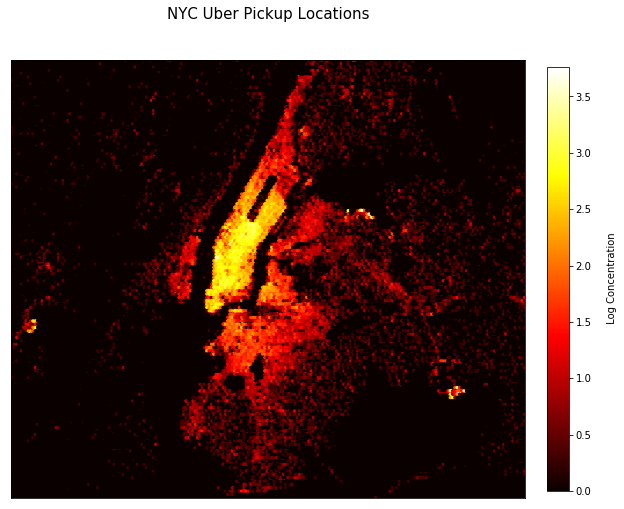

In [138]:
plt.figure(figsize=(10,10))
drawMap ("NYC Uber Pickup Locations\n",0,24)

The graph shows that the majority of Uber pickups take place in Manhattan, and spread across nearby boroughs, mostly in Brooklyna and Queens. Within Manhattan, the pickups are concentrated in midtown.

The three bright spots on the bottom right corner, on the left side, and on the right side of Manhattan are JFK airport, Newark airport, and LaGuardia airport, respectively, which suggests that passengers are using Uber to replace Taxi for transportation from airport to downtown.

### Data Visualization: Heat Map Morning Rush vs. Afternoon Rush Location


While the above graph tells us where the Uber pickups are overall, I want to further understand the location for Uber pickups in different time of the day. Therefore, I am going to zoom into the map, and draw two maps, one for Morning Rush (5am - 10am) and one for Afternoon Rush (3pm - 8pm). Since we have observed different patterns of Uber usage during weekdays vs. weekends, the following two maps will only use **Uber rides on weekdays**.

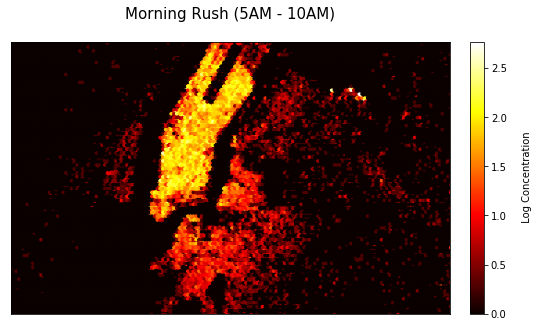

In [27]:
plt.figure(figsize=(9,5))
drawMap("Morning Rush (5AM - 10AM)", 4,10, weekday = True, zoomIn = True)

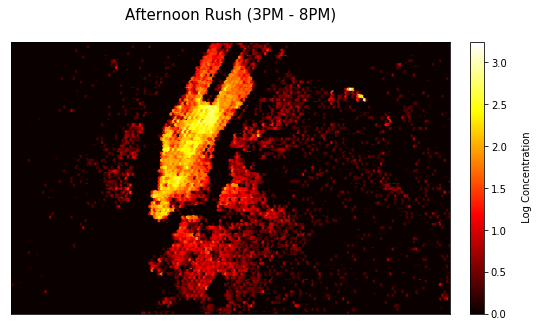

In [28]:
plt.figure(figsize=(9,5))
drawMap("Afternoon Rush (3PM - 8PM)", 14,20, weekday = True, zoomIn = True)

The differences between the two graphs are clear:
* **Morning Rush**: for Manhattan, the pickup locations are uniformly dispersed across uptown, midtown, and downtown regions. There are also a lot of pickups coming from Brooklyn, and the west side of Queens.
* **Afternoon Rush**: in contrast to Morning Rush, pickup locations within Manhattan are concentrated in midtown, near Rockfeller Center. At the same time, there are fewer pickups outside of Manhattan.

The implication from these observations are: in the morning of a weekday, people use Ubers to commute from home to work. Color of the heap map suggests that homes are more likely to be in either uptown or downtown than in midtown for people living in Manhattan. There are also a lot of people living in Brooklyn or Queens use Uber to commute to midtown Manhattan for work. Along that line, workplace are more likely to be in midtown, since midtown has the highest volume of Uber pickups during afternoon rush on a weekday. To add a quick note, the brighest spots on the afternoon rush map correspond to Wall Street, Rockfeller Center, just to name a few.

### Part 6: Compare Uber Pickups with Yellow Cab Pickups in NYC (June 2014)

Now I want to compare Uber pickups with Yellow Cab pickups in NYC in one day by hours, using data from June 2014. 

The questions I want to explore are: 
* Do passengers use more Ubers or Yellow Cabs?
* Do people prefer one to another during different time of the day?

In [45]:
url = 'https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2014-06.csv'
taxi_jun14 = pd.read_csv(url, usecols = [" pickup_datetime"," pickup_longitude"," pickup_latitude"])
taxi_jun14.columns = ['DateTime','Lon','Lat']

# local path
# path = '/Users/candicezs/Documents/Academic/Data_Bootcamp/Project/yellow_tripdata_2014-06.csv'

In [46]:
# convert DateTime column to datetime
taxi_jun14['DateTime'] = pd.to_datetime(taxi_jun14['DateTime'], format = '%Y-%m-%d %H:%M:%S')
# use extractDateTime() function to extract the datetime
extractDateTime(taxi_jun14, 'DateTime')

In [49]:
taxi_jun14.head()

,DateTime,Lon,Lat,Hour,Day,Weekday
0,2014-06-30 00:10:16,-73.994076,40.720134,0,30,Monday
1,2014-06-30 02:09:23,-74.007392,40.741116,2,30,Monday
2,2014-06-30 03:53:38,-74.005937,40.740136,3,30,Monday
3,2014-06-30 00:51:46,-73.986055,40.756408,0,30,Monday
4,2014-06-30 01:04:22,-73.948077,40.706921,1,30,Monday


In [50]:
taxi_jun14_byhour = hourlyPickUp(taxi_jun14, 'Hour', 'DateTime')
taxi_jun14_byhour.head()

,PickUps,Average_PickUp
Hour,,
0,584540,19485.0
1,423696,14123.0
2,312728,10424.0
3,222341,7411.0
4,165114,5504.0


### Data Visualization

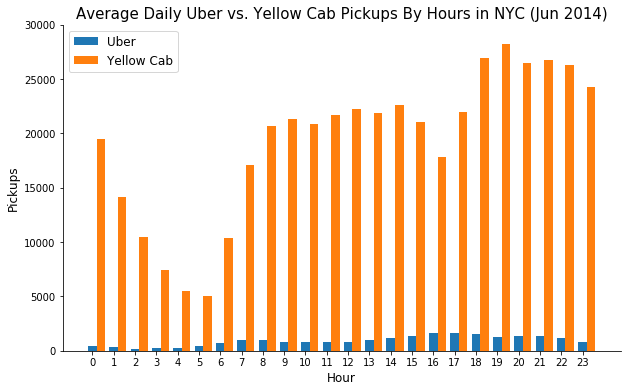

In [51]:
fig, ax = plt.subplots(figsize = (10,6))

bar_width = 0.4
plt.bar(uber_jun14_byhour.index, uber_jun14_byhour.Average_PickUp, bar_width, label='Uber')
plt.bar(taxi_jun14_byhour.index + bar_width, taxi_jun14_byhour.Average_PickUp, bar_width, label='Yellow Cab')

ax.set_xticks(range(0,24))
ax.set_ylim(0,30000)

ax.set_xlabel('Hour', fontsize = 12)
ax.set_ylabel('Pickups', fontsize = 12)
ax.set_title('Average Daily Uber vs. Yellow Cab Pickups By Hours in NYC (Jun 2014)', fontsize=15)

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

plt.legend(fontsize = 'large')

plt.show()

The data answers the first question: although Uber becomes more prominent in our life, the volume of Uber pickups is still not comparable to the number of Yellow Cab pickups in the city.

One interesting observation is that the number of Yellow Cab pickups reaches trough between 4 - 6 am and between 3 -
5pm. At the same time, the number of Uber pickups seems to increase during those two time periods. To better illustrate the relation between the number of Uber and Cab pickups during that time, I computed a "normalized" ratio of Yellow Cab to Uber by hour in a day. The following figure shows the ratio of Yellow Cab pickups to Uber pickups by hours, divided by the mean ratio, and minus 1 (so that the y axis would have a negative number to represent lower than average ratio).


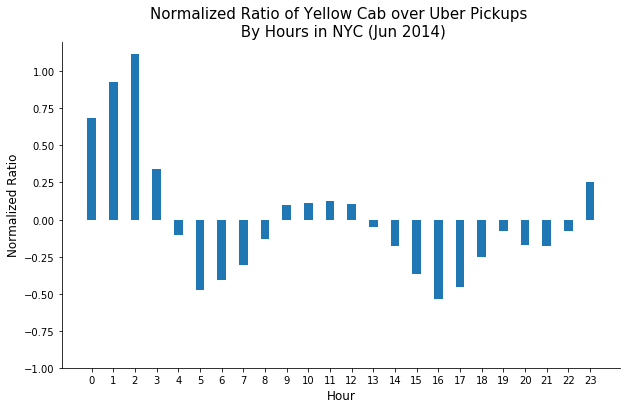

In [54]:
# plot the ratio
fig, ax = plt.subplots(figsize = (10,6))

taxi_jun14_byhour.Ratio = (taxi_jun14_byhour.Average_PickUp/uber_jun14_byhour.Average_PickUp)
nAvg = taxi_jun14_byhour.Ratio/np.mean(taxi_jun14_byhour.Ratio)-1
plt.bar(uber_jun14_byhour.index, nAvg, bar_width, label='Uber') 

ax.set_ylim(-1,1.2)

ax.set_xlabel('Hour', fontsize = 12)
ax.set_ylabel('Normalized Ratio', fontsize = 12)
ax.set_title('Normalized Ratio of Yellow Cab over Uber Pickups \n By Hours in NYC (Jun 2014)', fontsize=15)


ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

ax.set_xticks(range(0,24))

plt.show()

A greater than 0 ratio suggests that the ratio of Yellow Cab to Uber pickups is greater than the average ratio, and vice versa. Therefore, we can conclude that from 11pm - 3am the next mornings, there are a lot more Yellow Cab pickups than usual. And from 3am - 8am, as well as 2pm - 10pm, more Ubers get on road.

The reason for decreasing number of Cab rides between 4 - 6am and 3 - 5pm is the Taxi shifts. As this [Business Insider article](http://www.businessinsider.com/worst-time-to-hail-a-cab-in-nyc-2015-11) explains, taxi drivers change shift at around 4 - 5pm, which ironically is the peak of demand for rides. The introduction of Uber solves the ride shortage issue in NYC during the taxi shift periods, and successfully "steals" a lot of passengers from Yellow Cabs.

## Summary

*Uber pickups by hours in one day: *Number of pickups peaks from 5am to 9am in the morning, and from 3pm to 6pm in the evening. Number of pickups is the least from 1am - 4am, likely because a majority of Uber drivers are not full time drivers, and the demand for rides is the lowest during that time.

*Uber pickups by weekdays: *Thursday is the day when people demand the most Uber rides, followed by Friday and Wednesday. Numbers of Uber rides on weekends are the lowest in the week. Rides on weekdays are much higher because of the exogenous demand for rides to work and back home from work. Hence, we can conclude that **demand for Uber majorly comes from rides to work and back home during rush hours.**

*Uber pickups by hours and weekdays： *Rides on weekdays and weekends follow two distinctive hourly patterns. Rides peak in the mornings of weekdays - again proving the majority of Uber demands come from rush hours. There are high demand for rides on Thursday, Friday, and Saturday nights, followed by Wedsday and Tuesday, and eventually Monday and Sunday nights have the least demand. The trend demonstrates people's habits of seeking late night fun only on certain days of a week. The reason behind the pattern can be explained from both passenger's demand perspective, or from Uber driver's supply perspective. 

*Location of Uber pickups： *There are also a lot of people living in uptown or downtown Manhattan, Brooklyn and Queens use Uber to commute to midtown Manhattan for work. Workplaces are mostly concentrated in midtown, since midtown has the highest volume of Uber pickups during afternoon rush on a weekday.

*Comparing Uber with Yellow Cab: *Yellow Cabs are much more present in NYC than Ubers. However, Uber managed to steal lots of customers from Yellow Cabs during cab shifts, specifically 4 - 5pm, which happen to be the time when demands for rides are the highest. Therefore, the introduction of Uber provides a cure for ride shortages during that time.

Eventually, all the patters and observations can come in handy for both for passengers who want to avoid peak hours, and for Uber drivers looking for the next best time and location for more orders.